In [1]:
import numpy as np
import pandas as pd
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt
import urllib.request
import os
from math import floor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
torch.cuda.empty_cache()

In [2]:
name = 'margin'
group = 'drug_'
# group = 'gene_'

train_x = torch.load('train_x_'+ group + name)
train_y = torch.load('train_y_'+ group + name).squeeze(dim=1)
test_x = torch.load('test_x_'+ group + name)
test_y = torch.load('test_y_'+ group + name).squeeze(dim=1)

if torch.cuda.is_available():
    train_x, train_y, test_x, test_y = train_x.cuda(), train_y.cuda(), test_x.cuda(), test_y.cuda()
    
data_dim = train_x.size(-1)

In [5]:
train_y

tensor([0.7462, 0.5967, 0.4258,  ..., 0.5092, 0.7010, 0.5559], device='cuda:0')

In [4]:
class LargeFeatureExtractor(torch.nn.Sequential):
    def __init__(self, dropout_rate=0.2):
        super(LargeFeatureExtractor, self).__init__()
                # First linear layer
        self.add_module('linear1', torch.nn.Linear(data_dim, 500))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('norm1', torch.nn.BatchNorm1d(500))  # Normalization layer
        self.add_module('drop1', torch.nn.Dropout(dropout_rate))  # Dropout layer

        # Second linear layer
        self.add_module('linear2', torch.nn.Linear(500, 50))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('norm2', torch.nn.BatchNorm1d(50))  # Normalization layer
        self.add_module('drop2', torch.nn.Dropout(dropout_rate))  # Dropout layer

        # Final linear layer
        self.add_module('linear4', torch.nn.Linear(50, 2))

feature_extractor = LargeFeatureExtractor()

class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
                num_dims=2, grid_size= 100
            )
            self.feature_extractor = feature_extractor

            # This module will scale the NN features so that they're nice values
            self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)

        def forward(self, x):
            # We're first putting our data through a deep net (feature extractor)
            projected_x = self.feature_extractor(x)
            projected_x = self.scale_to_bounds(projected_x)  # Make the NN values "nice"

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()


training_iterations =  50
# Find optimal model hyperparameters
model.train()
likelihood.train()


# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
#mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data= 69214)
def train():
    iterator = tqdm.tqdm(range(training_iterations))
    for i in iterator:
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_x)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y)
        loss.backward()
        iterator.set_postfix(loss=loss.item())
        optimizer.step()


train()

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
    preds = model(test_x)



print('Test MAE: {}'.format(torch.mean(torch.abs(preds.mean - test_y))))





  0%|          | 0/50 [00:00<?, ?it/s]/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/linear_operator/utils/sparse.py:66: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  res = cls(index_tensor, value_tensor, interp_size)
/common/sghoshstat/ywu39393/DKL/lib/python3.9/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, sha

Test MAE: 0.01650272123515606


In [6]:

predict_value= torch.abs(preds.mean).cpu().numpy()
test_y = test_y.cpu().numpy()
#MAE
score_MAE = mean_absolute_error(predict_value, test_y)
print("The Mean Absolute Error of our Model is {}".format(round(score_MAE, 4)))

#r^2
score = r2_score(predict_value, test_y)
print("The R square of our model is {}%".format(round(score, 4)))
# RMSE 
score_rmse = np.sqrt(mean_absolute_error(predict_value, test_y))
print("The Mean Absolute Error of our Model is {}".format(round(score_rmse, 4)))

The Mean Absolute Error of our Model is 0.016499999910593033
The R square of our model is 0.9854%
The Mean Absolute Error of our Model is 0.12849999964237213


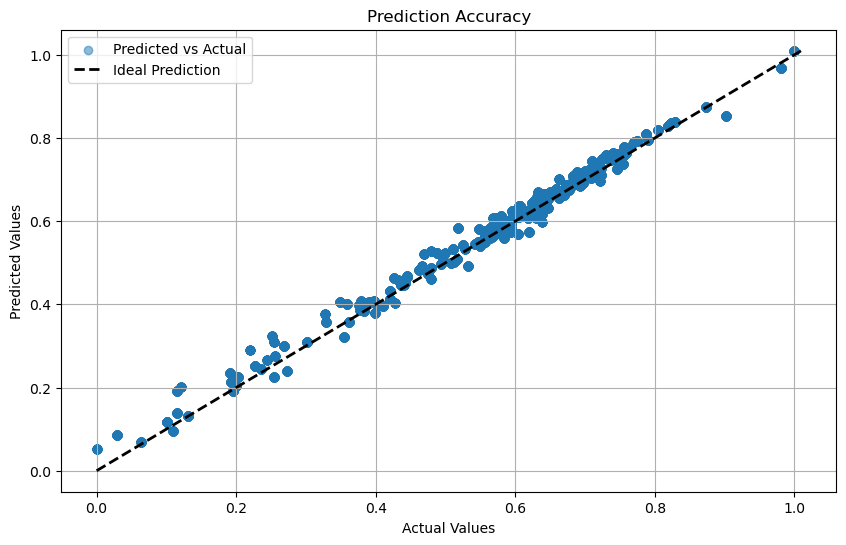

In [7]:
# print the prediction image

plt.figure(figsize=(10, 6))
plt.scatter(test_y, predict_value, alpha=0.5, label='Predicted vs Actual')

# Line plot for the perfect predictions
max_val = max(test_y.max(), predict_value.max())
min_val = min(test_y.min(), predict_value.min())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Accuracy')
plt.legend()
plt.grid(True)

In [12]:
print(preds.mean)

tensor([0.5457, 0.9679, 0.7383,  ..., 0.6417, 0.4510, 0.3958], device='cuda:0')


In [13]:
preds.variance

tensor([1.0000e-06, 1.0000e-06, 1.0000e-06,  ..., 1.0000e-06, 1.0000e-06,
        1.0000e-06], device='cuda:0')

In [10]:
print(preds.stddev.cpu())

tensor([0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010])


In [30]:
torch.save(preds.mean.cpu(), 'drug_y_mean')

In [31]:
torch.save(preds.stddev.cpu(), 'drug_y_std')